# Reproduce/beat the score of experimental band gap predictions

by: Alireza Faghaninia (alireza.faghaninia@gmail.com)

data is from: https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124

The main purpose of this notebook is to reproduce/beat the scores obtained in this paper but in semi-automatic workflow of matbench that is a much faster process requiring less domain knowledge.

* This notebook is an example of matbench that provide material scientists with a set of tools to automate their predictive modeling and get a benchmarking score to evaluate their future models.
* The input is only the chemical formulas! A single column used as the input of matbench workflow.
* Using [matminer](https://github.com/hackingmaterials/matminer) we extract 192 features from the chemical formulas.
* A two-stage model: due to the presence of metals (gap=0 eV) in the dataset, a classifier (metal or nonmetal) + a regressor seem to work better than trying to predict the gap with a single regressor.
* It is true that modeling in 2 stages look better but at the end we show that due to many nonmetals predicted as metal (bandgap=0.0), the overall cross-validation score is actually worse. Therefore, it is better just to optimize one regression model.
* To see how we corrected the duplicates in the database and train and optimize just one regression model, you can see

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import plotly as ply
import seaborn as sns
from matbench.core.analysis import Analysis

%matplotlib inline
ply.offline.init_notebook_mode(connected=True)
sns.set()
sns.set_context("poster", font_scale=1.1)

/Users/alirezafaghaninia/Documents/py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## All inputs:

In [2]:
# inputs
TARGET = ('Input Data', 'gap expt')
CALC_DIR = 'run_data'
SEED = 53
EXCLUDED_FEATURIZERS = [
    'CohesiveEnergy', 
#                         'AtomicPackingEf/ficiency',
                        'PartialRadialDistributionFunction',
                        'RadialDistributionFunction',
                        'CoulombMatrix',
                        'SineCoulombMatrix',
                        'OrbitalFieldMatrix',
#                         'MinimumRela/tiveDistances',
                        'ElectronicRadialDistributionFunction',
#     'YangSolidSolution',
'Miedema']
np.random.seed(SEED)
NFOLD = 5 # for cross-validation
N_JOBS = 4

## Read the data only containing chemical formula and experimentally measured band gap

In [3]:
from matbench.data.load import load_expt_gap
# df_init = pd.read_csv('../data/sources/gap_expt.csv')
df_init = load_expt_gap()
df_init.head()

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


## Feature generation: formula -> more than 320 features

In [4]:
from matbench.core.featurize import Featurize
featzer = Featurize(exclude=EXCLUDED_FEATURIZERS,
                    multiindex=True,
                    drop_featurized_col=True,
                    n_jobs=N_JOBS)

In [5]:
# df_featurized = featzer.featurize_formula(df_init, featurizers="all")
# df_featurized.to_pickle(os.path.join(CALC_DIR, 'df_featurized.pickle'))

df_featurized = pd.read_pickle(os.path.join(CALC_DIR, 'df_featurized.pickle'))

## Preprocessing (drop columns w/ more than 10% nulls + one-hot encoding of str columns)

In [6]:
from matbench.core.preprocess import Preprocess
from skrebate import ReliefF
prep = Preprocess()

df = prep.handle_na(df_featurized, max_na_frac=0.05, na_method='drop')
df = prep.prune_correlated_features(df, target_key=TARGET)
df = pd.get_dummies(df)

2018-09-26 22:37:41 INFO     Before handling na: 6354 samples, 237 features
2018-09-26 22:37:41 INFO     These 65 features were removed as they had more than 5.0% missing values:
{('CationProperty', 'range total_ioniz of cations'), ('ElementProperty', 'range velocity_of_sound'), ('CationProperty', 'range magn_moment of cations'), ('ElectronegativityDiff', 'std_dev EN difference'), ('CationProperty', 'range xtal_field_split of cations'), ('ElementProperty', 'range coefficient_of_linear_thermal_expansion'), ('CationProperty', 'std_dev magn_moment of cations'), ('CationProperty', 'mean magn_moment of cations'), ('CationProperty', 'maximum magn_moment of cations'), ('AtomicPackingEfficiency', 'mean abs simul. packing efficiency'), ('CationProperty', 'maximum total_ioniz of cations'), ('CationProperty', 'minimum total_ioniz of cations'), ('CationProperty', 'mean sat_magn of cations'), ('CationProperty', 'minimum so_coupling of cations'), ('ElectronegativityDiff', 'maximum EN difference'), (

In [7]:
# rf = ReliefF(n_features_to_select=50, n_jobs=N_JOBS)
# x = rf.fit_transform(df.drop(TARGET, axis=1).values, df[TARGET].values)
# pcacols = ["ReliefF feature {}".format(i) for i in range(x.shape[1])]
# df_rebate = pd.DataFrame(columns=pcacols, data=x, index=df.index)
# df_rebate.head()

## no feature selection
df_rebate = df.drop(TARGET, axis=1)
df_rebate.head()

,"(AtomicOrbitals, HOMO_energy)","(AtomicOrbitals, LUMO_energy)","(AtomicOrbitals, gap_AO)","(ElementProperty, minimum X)","(ElementProperty, maximum X)","(ElementProperty, range X)","(ElementProperty, mean X)","(ElementProperty, std_dev X)","(ElementProperty, minimum row)","(ElementProperty, maximum row)",...,"('AtomicOrbitals', 'LUMO_element')_Ti","('AtomicOrbitals', 'LUMO_element')_Tl","('AtomicOrbitals', 'LUMO_element')_Tm","('AtomicOrbitals', 'LUMO_element')_U","('AtomicOrbitals', 'LUMO_element')_V","('AtomicOrbitals', 'LUMO_element')_W","('AtomicOrbitals', 'LUMO_element')_Y","('AtomicOrbitals', 'LUMO_element')_Yb","('AtomicOrbitals', 'LUMO_element')_Zn","('AtomicOrbitals', 'LUMO_element')_Zr"
"(Input Data, formula)",,,,,,,,,,,,,,,,,,,,,
Hg0.7Cd0.3Te,-0.226594,-0.226594,0.000000,1.69,2.10,0.41,2.00350,0.179083,5.0,6.0,...,0,0,0,0,0,0,0,0,0,0
CuBr,-0.202272,-0.172056,0.030216,1.90,2.96,1.06,2.43000,0.749533,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
LuP,-0.206080,-0.155112,0.050968,1.27,2.19,0.92,1.73000,0.650538,3.0,8.0,...,0,0,0,0,0,0,0,0,0,0
Cu3SbSe4,-0.202272,-0.202272,0.000000,1.90,2.55,0.65,2.24375,0.401887,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0
ZnO,-0.338381,-0.222725,0.115656,1.65,3.44,1.79,2.54500,1.265721,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0


## Data visualization (unbalanced, many metals (target=0))

Let's start by the distribution of the target:

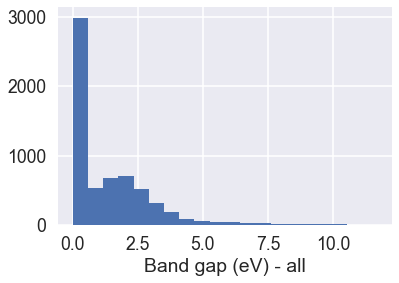

In [8]:
ax = df[TARGET].hist(bins=20)
ax.set_xlabel('Band gap (eV) - all');

In [9]:
print('{:.2f}% of the compounds are metal (expt gap == 0 eV)'.format(sum(df[TARGET]==0)/len(df)*100))

39.30% of the compounds are metal (expt gap == 0 eV)


We note that it is very unbalanced with most of the target variable being close to 0 (metals). Metals have very different properties and chemistry than nonmetals (gap>0). We return to this point in the following sections.

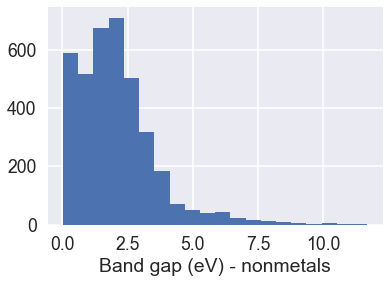

In [10]:
ax = df[TARGET][df[TARGET]>0.0].hist(bins=20)
ax.set_xlabel('Band gap (eV) - nonmetals');

Much better! Although, the high band-gap materials/insulators are still underrepresented.

## Further pre-processing of the data: standardization + PCA

In [11]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df.drop(TARGET, axis=1))

We generated more than 300 features some of which are highly cross-correlated and some may be just noise for this particular problem. I already tried training a random forest with a full feature set and the performance is much poorer than (RMSE difference of ~ 0.25 eV!). So, we proceed with standardization+PCA:

In [12]:
# from sklearn.decomposition import PCA
# N_COMPONENTS = 10
# pca = PCA(n_components=N_COMPONENTS)

In [13]:
# df_pca = pca.fit_transform(df_scaled)
# df_pca = pd.DataFrame(df_pca, columns=['PCA{}'.format(i+1) for i in range(N_COMPONENTS)], index=df.index)

In [14]:
# df_pca.head()

In [15]:
# plt.bar(height=pca.explained_variance_, x=range(1, N_COMPONENTS+1));
# plt.ylabel('explained variance');
# plt.xlabel('PCA eigenvectors #');

In [16]:
# from matminer.figrecipes.plot import PlotlyFig

# pf = PlotlyFig(df_pca, mode='notebook', margins=0, x_title='PCA1', y_title='PCA2')
# pf.xy(('PCA1', 'PCA2'), labels=df.index, colors=df[TARGET])

Looking at this plot we learn that the compounds don't particularly cluster based on the first 2 PCA directions. So, we need more than just 2 PCA features to model this data. Also, not even in terms of metal/nonmetal which may be one more reason to have separate classifier for metal/nonmetal.

In [17]:
df_reduced = df_rebate

# Training models

In [18]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_params_dict = {
        'n_estimators': [100, 200, 400],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    }

/Users/alirezafaghaninia/Documents/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [19]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train0, y_test0 = train_test_split(df_reduced, df[TARGET], test_size=0.2, random_state=SEED)

## 1) Single model on the mixed data (metals + nonmetals: higher RMSE)

In [20]:
model_reg1 = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=15,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=N_JOBS)
# with open(os.path.join(CALC_DIR, 'rf_mixed_optimized.pickle'), 'rb') as fm:
#     model_reg1 = pickle.load(fm)

In [21]:
model_reg1.fit(X_train0, y_train0)
with open(os.path.join(CALC_DIR, 'rf_mixed_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_reg1, fm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  4.7min finished


In [22]:
model_reg1.score(X_test0, y_test0)

-0.4183838120754042

In [23]:
abs(model_reg1.score(X_test0, y_test0))**0.5

0.6468259519186009

In [24]:
y_pred0 = model_reg1.predict(X_test0)
r2_score(y_test0, y_pred0)

0.816940304761123

In [25]:
model_reg1.best_params_

{'bootstrap': False,
 'max_features': 0.3,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'n_estimators': 100}

In [26]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=NFOLD, shuffle=False, random_state=SEED)
model_cv = RandomForestRegressor(**model_reg1.best_params_, n_jobs=N_JOBS)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv, df_reduced, df[TARGET], scoring='neg_mean_squared_error', cv=cv)]
print('{}-fold cross-validation scores for the basic model (metals+nonmentals)'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the basic model (metals+nonmentals)
RMSE: 0.7661 +- 0.0785


In [27]:
from matminer.figrecipes.plot import PlotlyFig
pf = PlotlyFig(mode='notebook', margins=0, x_title='Actual gap (eV)', y_title='Predicted gap (eV)')
pf.xy([(y_test0, y_pred0)], labels=X_test0.index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 2) Two models: 1 regressor on nonmetals + 1 classifier for metal/nonmetals

### Regressor for nonmetals (gap > 0)

In [28]:
df_reduced_nonmetal = df_reduced[df[TARGET]>0]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_reduced_nonmetal, df[df[TARGET]>0][TARGET], test_size=0.2, random_state=SEED)

In [30]:
model_reg2 = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=15,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=N_JOBS)
# with open(os.path.join(CALC_DIR, 'rf_optimized.pickle'), 'rb') as fm:
#     model_reg2 = pickle.load(fm)

# from matbench.automl.tpot_utils import TpotAutoml
# tpot = TpotAutoml(mode="regression",
#                       max_time_mins=120,
# #                   generations=1,
# #                   population_size=10,
#                       scoring='neg_mean_squared_error',
#                       random_state=SEED,
#                       feature_names=df_reduced.columns,
#                       n_jobs=N_JOBS,
#                       verbosity=2)
# model_reg2 = tpot

In [31]:
model_reg2.fit(X_train, y_train)
# with open(os.path.join(CALC_DIR, 'rf_optimized.pickle'), 'wb') as fm:
#     pickle.dump(model_reg2, fm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=4,
          param_distributions={'n_estimators': [100, 200, 400], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21), 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=53, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [32]:
# model_reg2.get_top_models()

In [33]:
model_reg2.score(X_test, y_test)

-0.22381989140001013

In [34]:
(abs(model_reg2.score(X_test, y_test)))**0.5

0.473096069947754

In [35]:
y_pred = model_reg2.predict(X_test)
r2_score(y_test, y_pred)

0.9145684950448425

In [36]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=NFOLD, shuffle=False, random_state=SEED)
model_cv2 = RandomForestRegressor(**model_reg2.best_params_, n_jobs=N_JOBS)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv2, df_reduced_nonmetal, df[df[TARGET]>0][TARGET], scoring='neg_mean_squared_error', cv=cv)]
print('{}-fold cross-validation scores for the model only nonmentals'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the model only nonmentals
RMSE: 0.4933 +- 0.0347


In [37]:
from matminer.figrecipes.plot import PlotlyFig
pf = PlotlyFig(mode='notebook', margins=0, x_title='Actual gap (eV)', y_title='Predicted gap (eV)')
pf.xy([(y_test, y_pred)], labels=X_test.index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


###  Metal vs. Non-metal Classifier

In [38]:
cassification_ismetal = df[TARGET].apply(lambda x: int(x==0))
sum(cassification_ismetal)/len(cassification_ismetal)

0.392954801351134

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_reduced, cassification_ismetal, test_size=0.2, random_state=SEED)

In [40]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=NFOLD, shuffle=False, random_state=SEED)

In [41]:
from sklearn.ensemble import RandomForestClassifier # actually SVC here scores similarly

model_cls = RandomizedSearchCV(estimator=RandomForestClassifier(
    class_weight={0: 1., 1:1./(sum(cassification_ismetal)/len(df))}), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=50,
                           scoring='roc_auc',
                           cv=cv,
                           verbose=1,
                           n_jobs=N_JOBS)
# with open(os.path.join(CALC_DIR, 'classifier_optimized.pickle'), 'rb') as fm:
#     model_cls = pickle.load(fm)

# tpot_cls = TpotAutoml(mode="classification",
#                       max_time_mins=120,
# #                       generations=1,
# #                       population_size=10,
#                       scoring='roc_auc',
#                       random_state=SEED,
#                       feature_names=df_reduced.columns,
#                       n_jobs=N_JOBS,
#                       verbosity=2)
# model_cls = tpot_cls

In [42]:
model_cls.fit(X_train, y_train)
# with open(os.path.join(CALC_DIR, 'classifier_optimized.pickle'), 'wb') as fm:
#     pickle.dump(model_cls, fm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 15.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=53, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 1.0, 1: 2.544821940237413}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'n_estimators': [100, 200, 400], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21), 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs',

In [43]:
# model_cls.get_top_models()

In [44]:
model_cls.score(X_test, y_test)

0.9806323085949759

In [45]:
from sklearn.model_selection import cross_val_score

model_cv3 = RandomForestClassifier(**model_cls.best_params_, n_jobs=N_JOBS)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv3, df_reduced, cassification_ismetal, scoring='roc_auc', cv=cv)]
print('{}-fold cross-validation scores for the classification (metal/nonmetal) model'.format(NFOLD))
print('ROC_AUC: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the classification (metal/nonmetal) model
ROC_AUC: 0.9919 +- 0.0023


In [46]:
from sklearn.metrics import confusion_matrix
from collections import Counter
y_pred = model_cls.predict(X_test)
# y_pred = list(map(int, model_cls.predict_proba(X_test)[:, 1] > 0.55)) # if .8, we only throw away 3.6% of the data as metal
cm = confusion_matrix(y_test, y_pred)/np.array([Counter(y_pred)[0], Counter(y_pred)[1]])

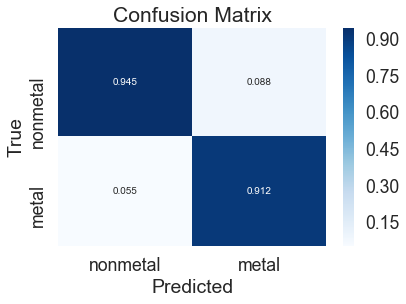

In [47]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3f');
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['nonmetal', 'metal']); 
ax.yaxis.set_ticklabels(['nonmetal', 'metal']);

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = model_cls.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

Text(0,0.5,'True positive rate')

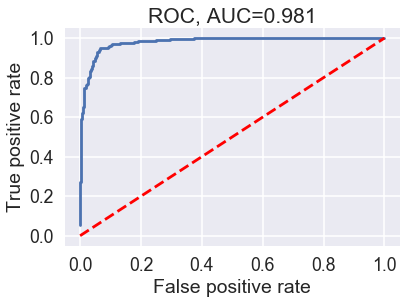

In [49]:
plt.plot(fpr, tpr);
plt.plot([0., 1.], [0., 1.], 'r--')
plt.title('ROC, AUC={0:.3f}'.format(roc_auc_score(y_test, y_pred_proba)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [50]:
# df[TARGET].hist(bins=50)
# plt.xlim([0, 0.9])

## Putting it all together: classification first and then regression on predicted nonmetals, what's the RMSE?

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class ProductionModel(BaseEstimator, TransformerMixin):
    """
    Predicts the target using a sequence of classifier (target==0 or not) and regressor that is fit on the 
    portion of the data with target != 0
    """
    def __init__(self, classifier, regressor):
        self.classifier = classifier
        self.regressor = regressor
    
    def fit(self, X=None, y=None):
        is_y_0 = y==0.0
        self.classifier.fit(X, is_y_0.apply(int))
        self.regressor.fit(X[~is_y_0], list(map(int, y[~is_y_0])))        
    
    def predict(self, X):
        is_metal = self.classifier.predict(X)
        y_pred = self.regressor.predict(X)
        for idx, pred_reg in enumerate(y_pred):
            if is_metal[idx]:
                y_pred[idx] = 0.0
        return y_pred

In [52]:
production_model = ProductionModel(model_cv3, model_cv2) # model_cv2 is regression

In [54]:
X = df_reduced 
y_true = df[TARGET]

In [55]:
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

cv = KFold(n_splits=NFOLD, shuffle=False, random_state=SEED)

y_pred_prod = [np.sqrt(abs(score)) for score in cross_val_score(production_model, X, y_true, scoring='neg_mean_squared_error', cv=cv)]
print('{}-fold cross-validation scores for the model only nonmentals'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the model only nonmentals
RMSE: 0.9919 +- 0.0023


Just a test score:

In [56]:
production_model.fit(X_train0, y_train0)

In [57]:
y_pred_prod = production_model.predict(X_test0)

In [58]:
from sklearn.metrics import mean_squared_error, r2_score

print('R2: {}'.format(r2_score(y_test0, y_pred_prod)))
print('RMSE: {}'.format((mean_squared_error(y_test0, y_pred_prod))**0.5))

R2: 0.7542865633480316
RMSE: 0.74938590778433


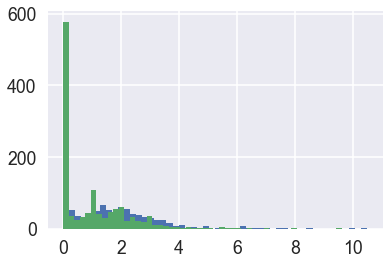

In [65]:
plt.hist(y_test0, bins=50)
plt.hist(y_pred_prod, bins=50);

In [66]:
from matminer.figrecipes.plot import PlotlyFig
pf = PlotlyFig(mode='notebook', margins=0, x_title='Actual gap (eV)', y_title='Predicted gap (eV)')
pf.xy([(y_test0, y_pred_prod)], labels=X_test.index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
print(asfgccc) # just to end the notebook

## Metal vs. low-gap semiconductor vs. semiconductor vs. insulator classifier

In [ ]:
thresholds=(-1000, 0.0, 1.5, 1000.0)
df['multi_class'] = df[TARGET]
for iclass in range(len(thresholds)-1):
    df['multi_class'][(df[TARGET]>thresholds[iclass]) & (df[TARGET]<=thresholds[iclass+1])] = iclass

df['multi_class'] = df['multi_class'].astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_reduced, df['multi_class'], test_size=0.2, random_state=SEED)

In [ ]:
y_test.hist();

In [ ]:
from sklearn.ensemble import RandomForestClassifier # actually SVC here scores similarly

model_multicls = RandomizedSearchCV(estimator=RandomForestClassifier(
    class_weight={i:len(df)/sum(df['multi_class']==i) for i in range(len(df['multi_class'].unique()))}), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=20,
                           scoring='f1_weighted',
                           cv=cv,
                           verbose=1,
                           n_jobs=N_JOBS)
# with open(os.path.join(CALC_DIR, 'multiclass_classifier_optimized.pickle'), 'rb') as fm:
#     model_cls = pickle.load(fm)

In [ ]:
model_multicls.fit(X_train, y_train.values)
with open(os.path.join(CALC_DIR, 'multiclass_classifier_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_cls, fm)

In [ ]:
from sklearn.metrics import confusion_matrix
from collections import Counter
y_pred = model_multicls.predict(X_test)
cm = confusion_matrix(y_test, y_pred)/np.array([Counter(y_pred)[i] for i in range(len(thresholds)-1)])

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3f', annot_kws={"size": 20});
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['insulator', 'semi', 'lowgap', 'metal']); 
ax.yaxis.set_ticklabels(['insulator', 'semi', 'lowgap', 'metal']);

As we see the score of multi-class classification is lower than metal/nonmetal only